In [580]:
"""Script to read in imspector data of a TM/EOD 4D scan and fit 2D Gaussians to
it for further processing."""

from tkinter import Tk
from tkinter.filedialog import askopenfilename
from scipy.optimize import least_squares

import matplotlib.pyplot as plt
import numpy as np

from blutils.fit_2dgaussians import fit_gaussian_to_imgs
import blutils


# Copied from Alba's script. We should have model functions in cpufit directly.
# https://github.com/svnddlsns/ag_scripts/blob/main/exc_beam_drift_evaluation.ipynb
def two_dimensional_elliptical_gaussian(x, y, amplitude, x0, y0, sigma_x,
                                        sigma_y, offset, angle):
    """
    Compute a two-dimensional elliptical Gaussian function.

    Parameters:
    - x, y: 1D arrays representing the x and y coordinates
    - amplitude: amplitude of the Gaussian
    - x0, y0: center coordinates of the Gaussian
    - sigma_x, sigma_y: standard deviations in x and y directions
    - offset: amplitude offset
    - angle: rotation angle in degrees

    Returns:
    - 2D array representing the computed elliptical Gaussian function
    """
    angle_rad = angle
    # angle_rad = np.deg2rad(angle)
    x_rot = (x - x0) * np.cos(angle_rad) - (y - y0) * np.sin(angle_rad)
    y_rot = (x - x0) * np.sin(angle_rad) + (y - y0) * np.cos(angle_rad)
    gaussian = amplitude * np.exp(-((x_rot / sigma_x)**2 +
                                    (y_rot / sigma_y)**2) / 2) + offset
    return gaussian


# GUI for selecting measuremet data.
root = Tk()
root.withdraw()

# Pre-select most recently modified directory
basedir = blutils.group_storage_path('')
# basedir = blutils.group_storage_path('projects/Calibration/mf3 EOD')
initial_folders = [folder for folder in basedir.iterdir()]
initial_folders.sort(key=lambda folder: (basedir / folder).stat().st_mtime,
                     reverse=True)

initial_folder = basedir / initial_folders[0]

filename = askopenfilename(initialdir=(basedir / initial_folder),
                           filetypes=[('msr Files', '*.msr')])
root.destroy()

print('Selected file:', filename)

# Read in the data as an xarray DataArray.
_, arr = blutils.obf_support.read_xarray(filename, stack_idx=2)
arr = arr.transpose()


Selected file: Y:/projects/Calibration/mf3 EOD/2024-03-25/scan XY stage 5x5um TM 4x4um 560 bead 2 new calib 2 #2.msr


### Dimensions check

In [581]:
arr.shape

(5, 5, 45, 45)

In [582]:
# fast axes scan
fast_num_px = arr.shape[0]
# fast_range = 5000 # nm
fast_range = 1200

# slow axes scan
slow_num_px = arr.shape[2]
# slow_range = 4000 # nm
slow_range = 2000
print(f'Fast axis limit: {(fast_num_px-1)*fast_range/fast_num_px/2} nm')
print(f'Slow axis limit: {(slow_num_px-1)*slow_range/slow_num_px/2} nm')

Fast axis limit: 480.0 nm
Slow axis limit: 977.7777777777778 nm


In [583]:
arr['u'].values

array([-1.6, -0.8,  0. ,  0.8,  1.6])

In [584]:
arr['x'].values

array([-2.44444444, -2.33333333, -2.22222222, -2.11111111, -2.        ,
       -1.88888889, -1.77777778, -1.66666667, -1.55555556, -1.44444444,
       -1.33333333, -1.22222222, -1.11111111, -1.        , -0.88888889,
       -0.77777778, -0.66666667, -0.55555556, -0.44444444, -0.33333333,
       -0.22222222, -0.11111111,  0.        ,  0.11111111,  0.22222222,
        0.33333333,  0.44444444,  0.55555556,  0.66666667,  0.77777778,
        0.88888889,  1.        ,  1.11111111,  1.22222222,  1.33333333,
        1.44444444,  1.55555556,  1.66666667,  1.77777778,  1.88888889,
        2.        ,  2.11111111,  2.22222222,  2.33333333,  2.44444444])

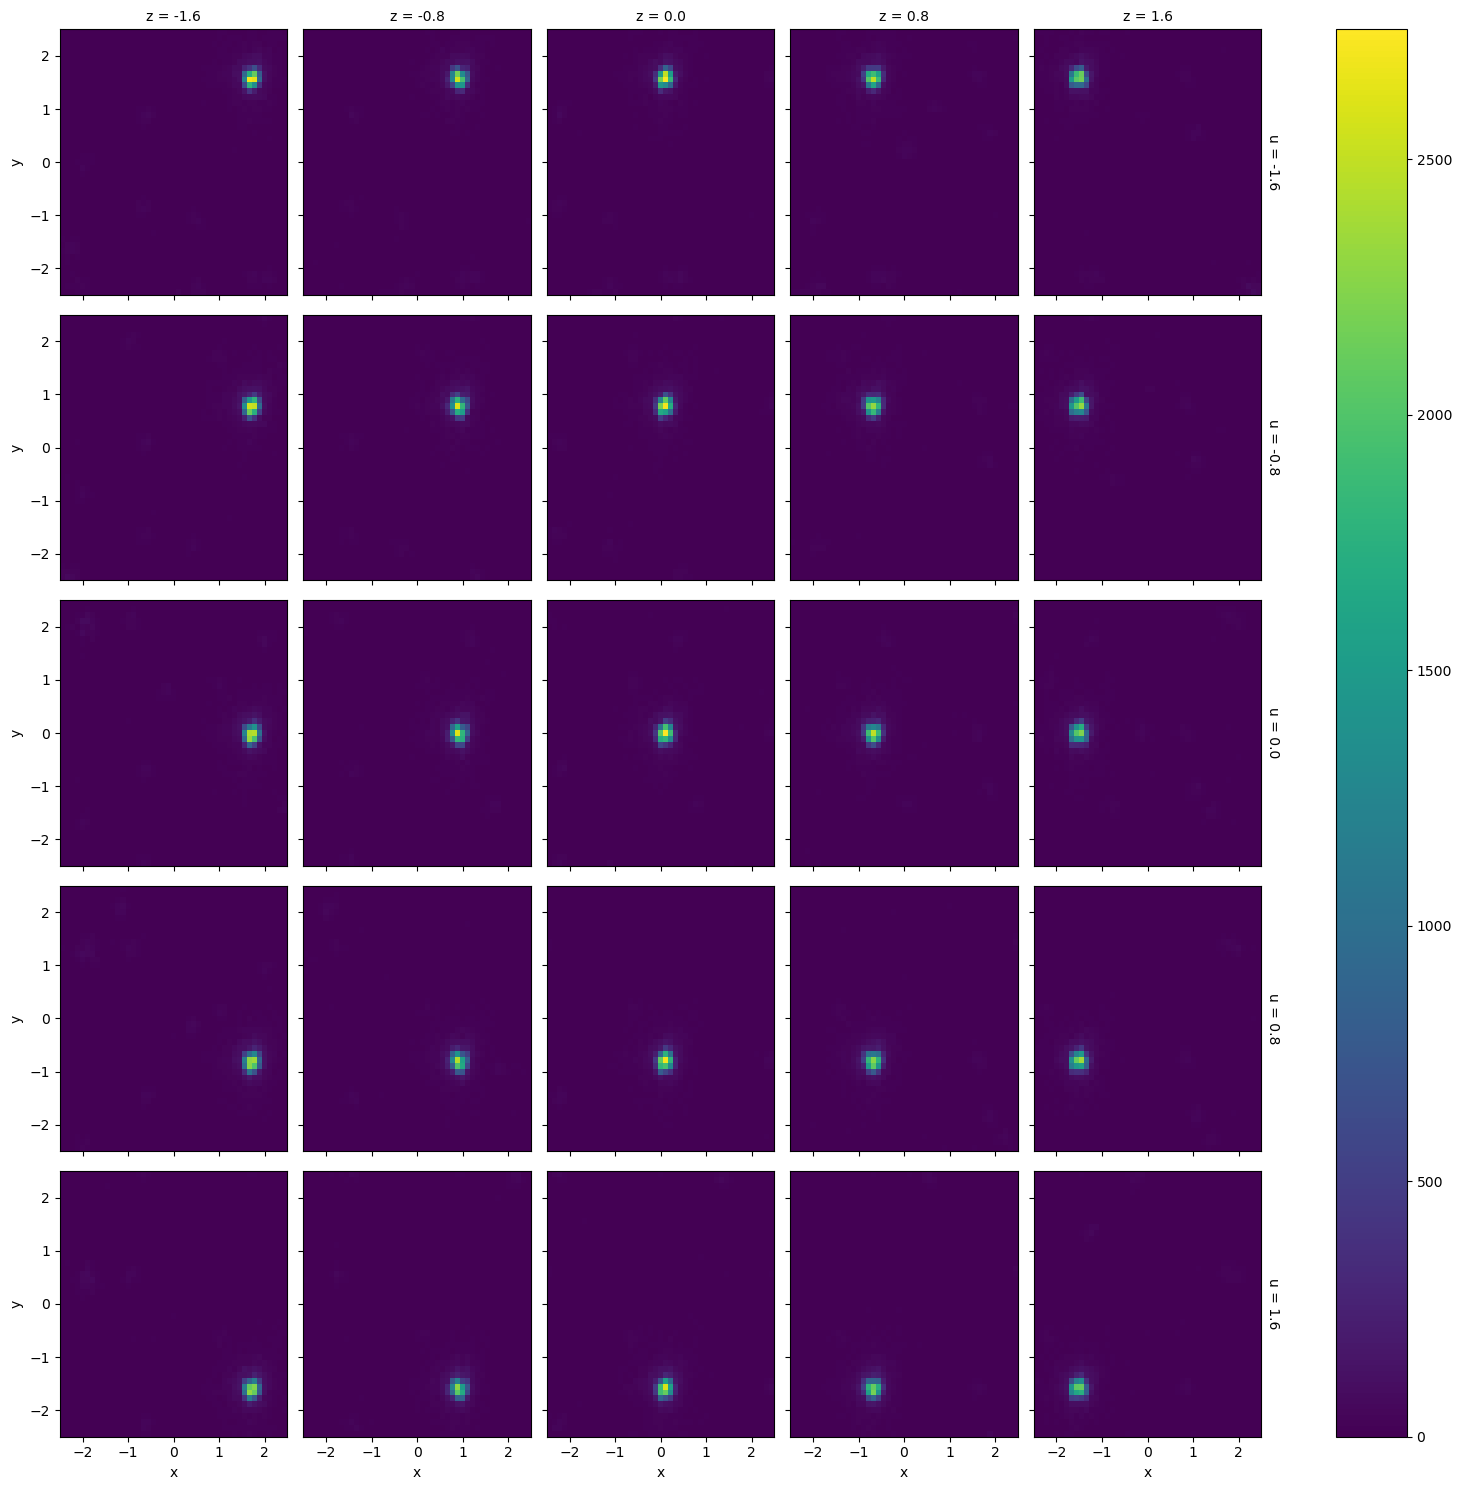

In [585]:
arr.plot(col='z', row='u')
plt.show()

In [586]:
# Shape data to be fed into cpufit.
stack_to_fit = arr.values.reshape(
    (arr.shape[0] * arr.shape[1], *arr.shape[2:])).astype(np.float32)

parameters, chi_sq = fit_gaussian_to_imgs(stack_to_fit, chunk_size=100)

xx, yy = np.meshgrid(np.arange(stack_to_fit.shape[1]),
                     np.arange(stack_to_fit.shape[2]),
                     indexing='xy')
fits = np.array([
    two_dimensional_elliptical_gaussian(xx, yy, *params)
    for params in parameters
])
arr_fits = arr.copy(data=fits.reshape(arr.shape))

# CAREFUL/FIXME: this takes the global maximum, not per frame.
errors = []
for frame, fit in zip(stack_to_fit, fits):
    errors.append(np.abs(frame - fit) / frame.max())
arr_err = arr.copy(data=np.array(errors).reshape(arr.shape))

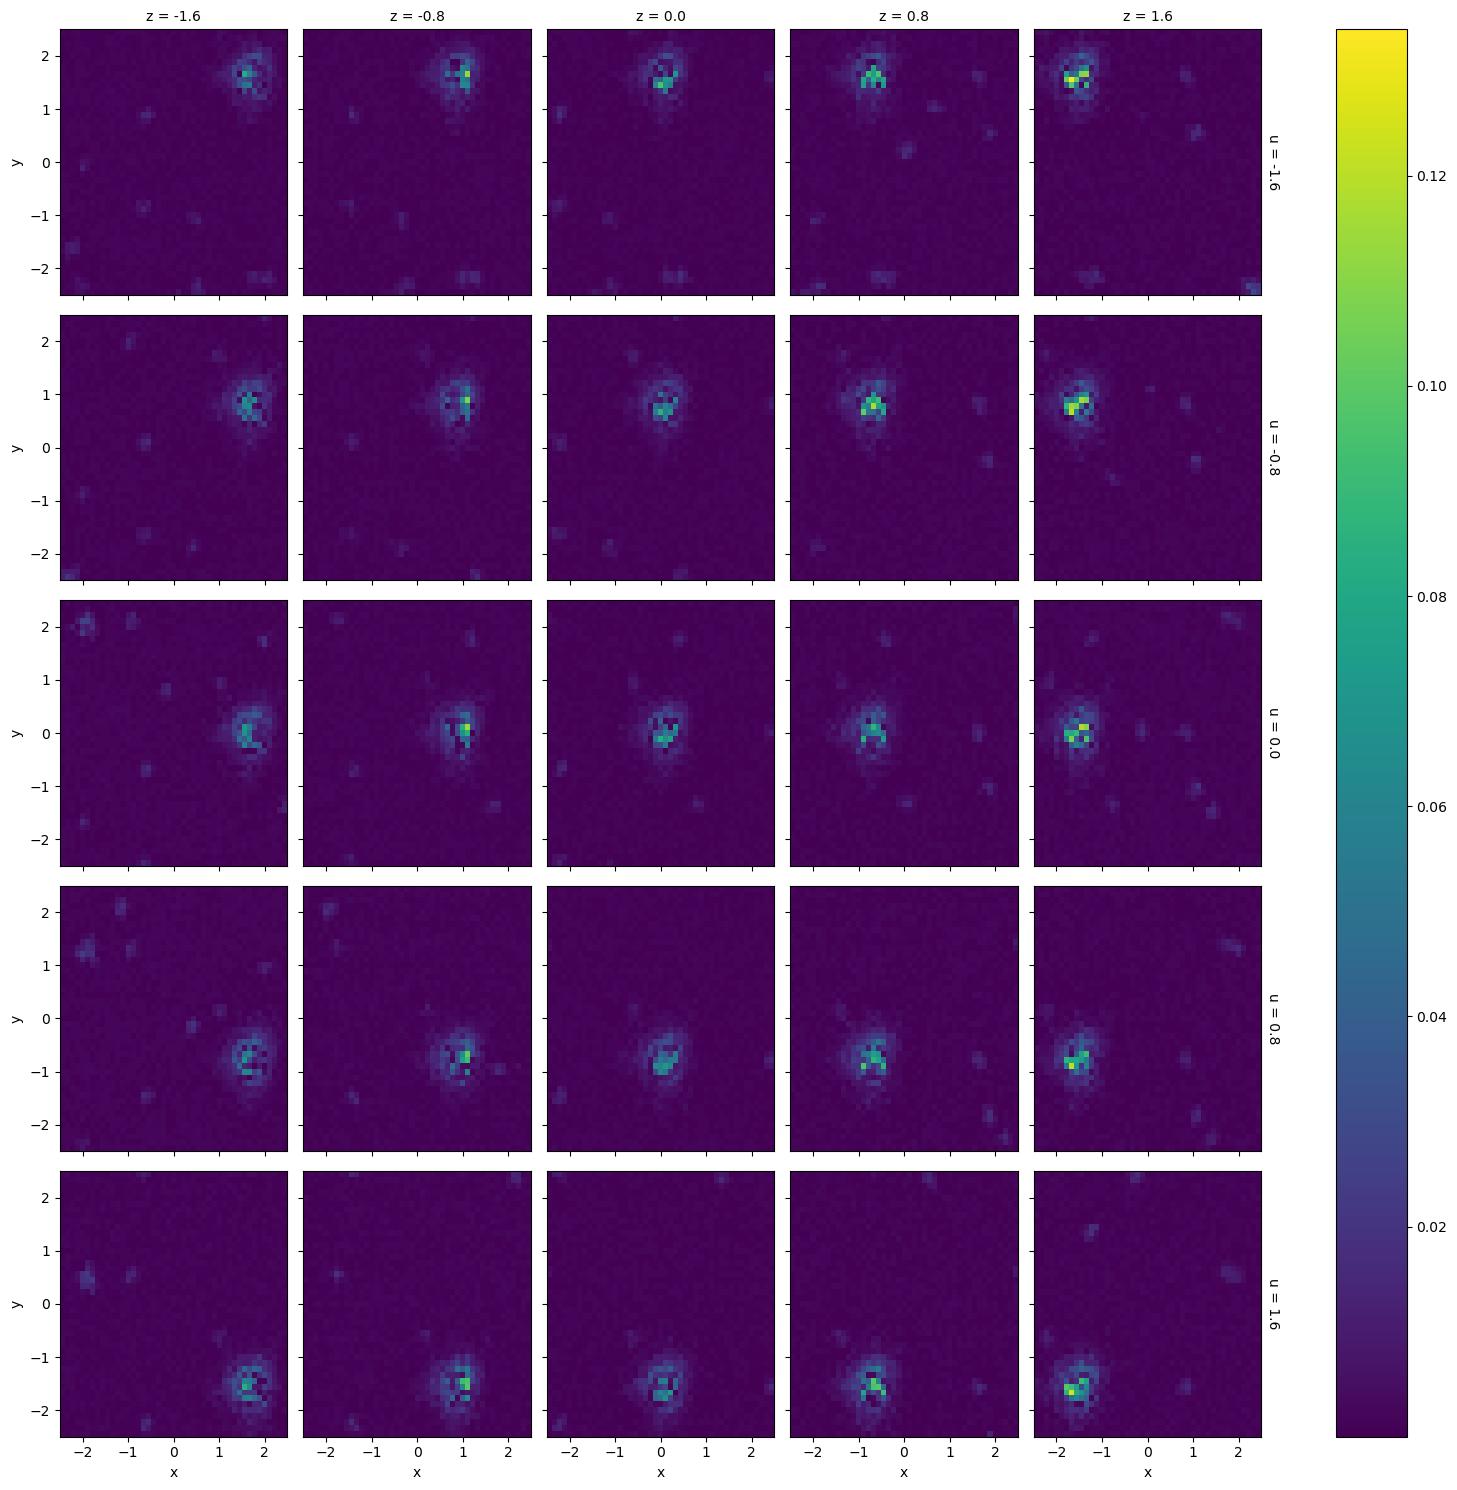

In [587]:
arr_err.plot(col='z', row='u')
plt.show()

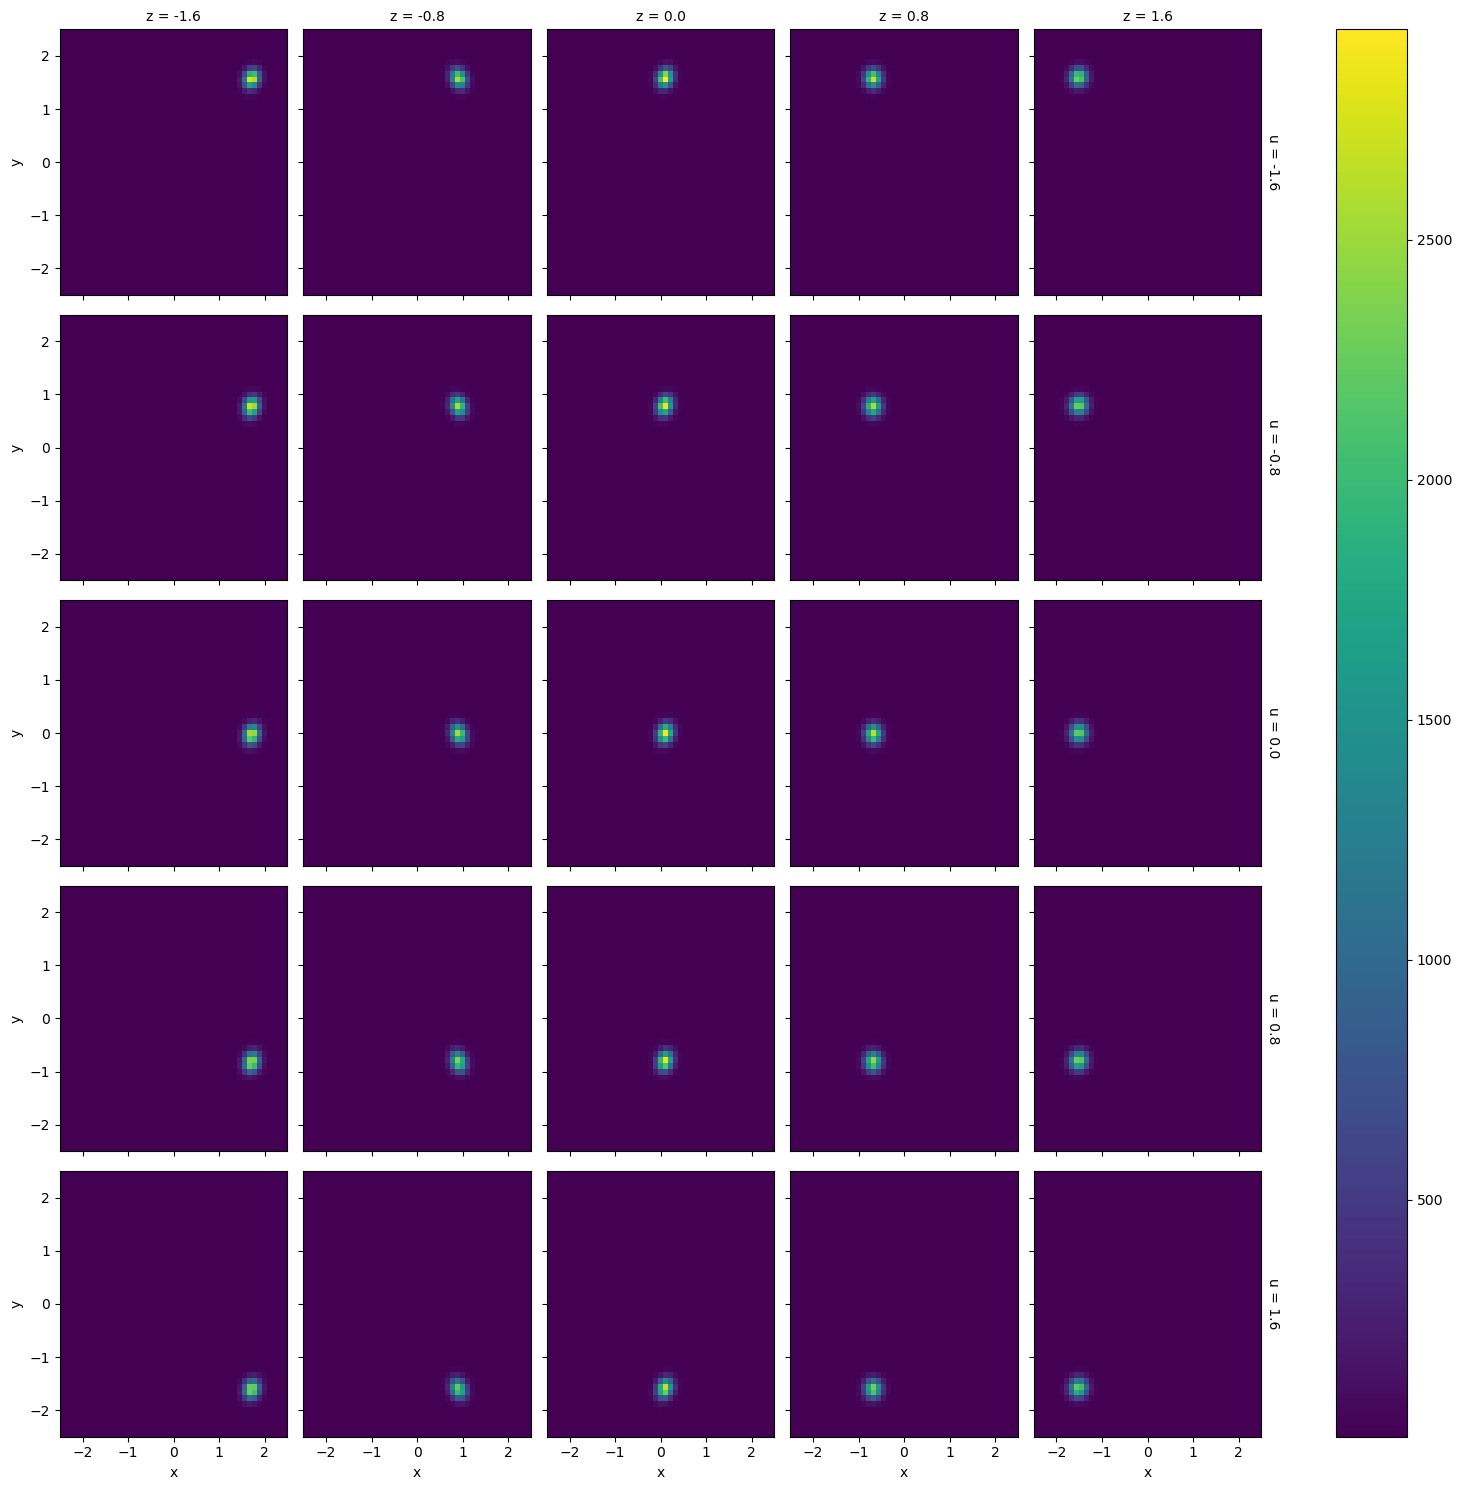

In [588]:
arr_fits.plot(col='z', row='u')
plt.show()

In [589]:
def fit_transformation(xf, yf, orig_points):
    """
    Fit a combined rotation, shear, and scaling transformation to measured points.

    Parameters:
    xf, yf : 2D numpy arrays representing the measured x and y coordinates of the grid points.

    Returns:
    A dictionary containing the fit parameters: scale factors, rotation angle, and shear factors.
    """

    # # Original grid points (assuming a unit grid for simplicity)
    # X, Y = np.meshgrid(range(xf.shape[1]), range(xf.shape[0]))
    # orig_points = np.vstack([X.ravel(), Y.ravel(), np.ones(X.size)])

    # Measured points
    measured_points = np.vstack([xf.ravel(), yf.ravel()])

    def transformation_model(params, orig_points):
        # scale_x, scale_y, theta, shear_x, shear_y = params
        scale_x, scale_y, theta, shear_x, offset_x, offset_y = params
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        shear_matrix = np.array([
            [1, 0],
            [shear_x, 1]
        ])
        scale_matrix = np.array([
            [scale_x, 0],
            [0, scale_y]
        ])
        # offset_x, offset_y = 0, 0
        offset = np.array([[offset_x], [offset_y]])
        return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(scale_matrix, orig_points[:2])) + offset

    def residuals(params, orig_points, measured_points):
        transformed_points = transformation_model(params, orig_points)
        return ((transformed_points - measured_points)**2).ravel()

    # Initial guess: No rotation, no shear, unit scale, no offset
    initial_guess = [1, 1, 0, 0, 0 ,0]

    result = least_squares(residuals, initial_guess, args=(orig_points, measured_points))

    scale_x, scale_y, theta, shear_x, offset_x, offset_y = result.x

    return {
        'scale_x': scale_x,
        'scale_y': scale_y,
        'rotation_angle': theta * (180 / np.pi),  # Convert to degrees
        'shear_x': shear_x,
        'offset_x': offset_x,
        'offset_y': offset_y,
        'transformed_points': transformation_model(result.x, orig_points),
        'residuals': result.fun
    }

In [590]:
parameters.shape

(25, 7)

In [591]:
c = 5/45 # conversion factor from pixels to microns
# c = 1/20
fast_scan_dim = arr.shape[0] # number of points in the EOD scan, assumed to be squared for now

# x, y = np.sort(parameters[:,1].reshape(fast_scan_dim,fast_scan_dim),axis=1), np.sort(parameters[:,2].reshape(fast_scan_dim,fast_scan_dim),axis=0)
# xf, yf = (x-x[0,0])*c, (y-y[0,0])*c
x, y = parameters[:,1].reshape(fast_scan_dim,fast_scan_dim), parameters[:,2].reshape(fast_scan_dim,fast_scan_dim)
xf, yf = (x-(arr.x.size-1)/2)*c, (y-(arr.y.size-1)/2)*c

fast_scan_range = arr.u.values
# X, Y = np.meshgrid(fast_scan_range-fast_scan_range[0], fast_scan_range-fast_scan_range[0])
# orig_points = np.vstack([X.ravel(), Y.ravel(), np.ones(X.size)]) 
X, Y = np.meshgrid(fast_scan_range, fast_scan_range)
orig_points = np.vstack([X.ravel(), Y.ravel()]) 

transformation_params = fit_transformation(xf, yf, orig_points=orig_points)
keys_to_print = ['scale_x', 'scale_y', 'rotation_angle', 'shear_x', 'offset_x', 'offset_y']
for key in keys_to_print:
    print(f'{key}: {transformation_params[key]}')

scale_x: -1.0046756781188253
scale_y: -0.9921277171338185
rotation_angle: -0.021479115477157897
shear_x: -0.0061035081666792
offset_x: 0.11249687175299271
offset_y: -0.01173278976925786


Text(0, 0.5, 'Transformation Model Residuals')

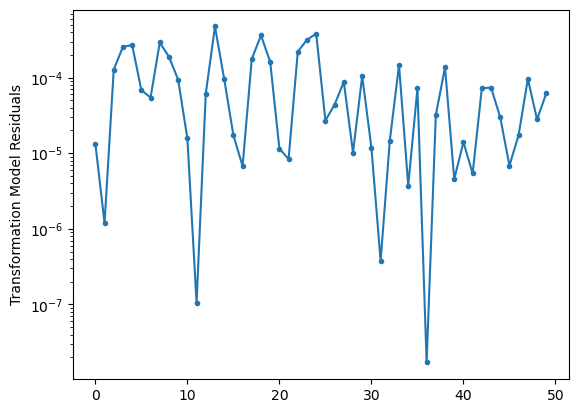

In [592]:
res = transformation_params['residuals']
plt.plot(res, marker='.')
plt.yscale('log')
plt.ylabel('Transformation Model Residuals')


Text(0, 0.5, 'u [µm]')

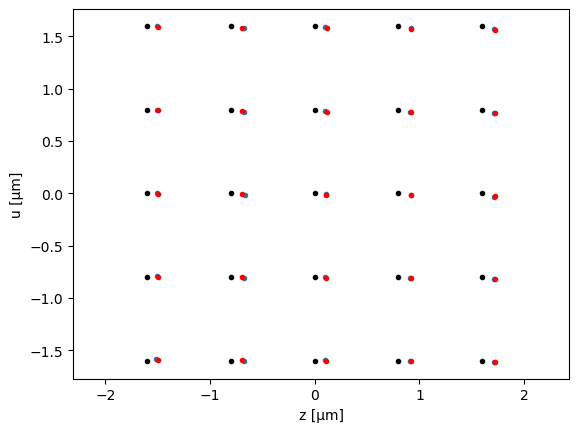

In [593]:
plt.scatter(xf,yf,marker='.')
plt.scatter(orig_points[0,:],orig_points[1,:],color='k', marker='.')
plt.scatter(transformation_params['transformed_points'][0].reshape(fast_scan_dim,fast_scan_dim),transformation_params['transformed_points'][1].reshape(fast_scan_dim,fast_scan_dim),color='r', marker='.')
plt.axis('equal')
plt.xlabel('z [µm]')
plt.ylabel('u [µm]')
# plt.yticks(np.arange(0, 5, 1))


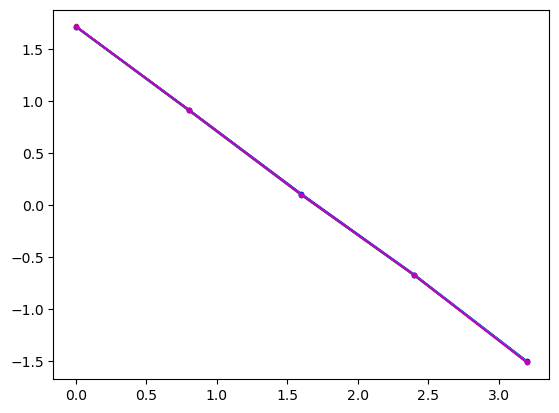

In [594]:
# colors = ['r','g','b','c','m','y','k']
colors = ['r','g','b','c','m']
for i, color in enumerate(colors):
    plt.plot(fast_scan_range-fast_scan_range[0], xf[i], color=color, marker='.')
    # plt.xlim([0,4])
    # plt.ylim([0,4])

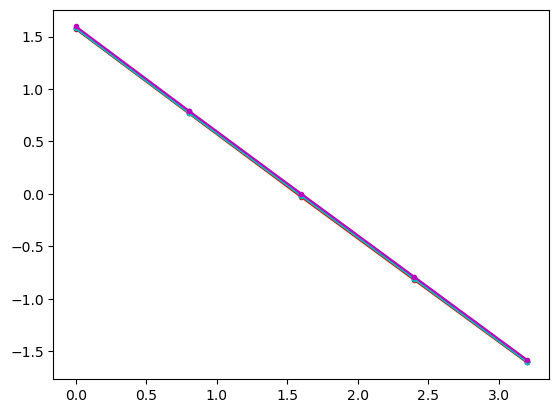

In [595]:
# colors = ['r','g','b','c','m','y','k']
colors = ['r','g','b','c','m']
for i, color in enumerate(colors):
    plt.plot(fast_scan_range-fast_scan_range[0], yf.T[i], color=color, marker='.')
    # plt.xlim([0,4])
    # plt.ylim([0,4])

In [596]:
print(transformation_params['transformed_points'].shape)
transformation_params['transformed_points']

(2, 25)


array([[ 1.72056925e+00,  9.16830607e-01,  1.13091960e-01,
        -6.90646687e-01, -1.49438533e+00,  1.72027171e+00,
         9.16533063e-01,  1.12794416e-01, -6.90944231e-01,
        -1.49468288e+00,  1.71997417e+00,  9.16235519e-01,
         1.12496872e-01, -6.91241775e-01, -1.49498042e+00,
         1.71967662e+00,  9.15937975e-01,  1.12199328e-01,
        -6.91539319e-01, -1.49527797e+00,  1.71937908e+00,
         9.15640431e-01,  1.11901784e-01, -6.91836863e-01,
        -1.49557551e+00],
       [ 1.56525756e+00,  1.57046450e+00,  1.57567145e+00,
         1.58087839e+00,  1.58608533e+00,  7.71555440e-01,
         7.76762384e-01,  7.81969328e-01,  7.87176272e-01,
         7.92383216e-01, -2.21466776e-02, -1.69397337e-02,
        -1.17327898e-02, -6.52584587e-03, -1.31890197e-03,
        -8.15848796e-01, -8.10641852e-01, -8.05434908e-01,
        -8.00227964e-01, -7.95021020e-01, -1.60955091e+00,
        -1.60434397e+00, -1.59913703e+00, -1.59393008e+00,
        -1.58872314e+00]])

In [597]:
# a = arr['u'].values-arr['u'].values[0]
# X, Y = np.meshgrid(a, a)
# orig_points = np.vstack([X.ravel(), Y.ravel(), np.ones(X.size)])
# orig_points